In [1]:
from __future__ import print_function
import os
import sys
import time
import datetime
import json
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience

# Ensure inline plotting for Jupyter Notebook
%matplotlib inline


In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [4]:
# Define constants for actions
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3



# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}
num_actions = len(actions_dict)

In [5]:
# Function to play the game
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False


In [6]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [7]:
def build_model(maze):
    # Calculate the size of the input layer (number of features)
    input_size = np.prod(maze.shape)

    # Define the model
    model = tf.keras.Sequential()

    # Add an input layer
    model.add(tf.keras.layers.Input(shape=(input_size,)))

    # Add hidden layers
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))

    # Add output layer
    model.add(tf.keras.layers.Dense(4, activation='linear'))  # 4 outputs for LEFT, UP, RIGHT, DOWN

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    return model


In [8]:
def qtrain(model, maze, **opt):

    # Configurable parameters
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    epsilon = opt.get('epsilon', 1.0)
    min_epsilon = opt.get('min_epsilon', 0.05)
    epsilon_decay = opt.get('epsilon_decay', 0.995)

    start_time = datetime.datetime.now()

    # Initialize environment
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)

    win_history = []
    hsize = qmaze.maze.size // 2  # Window size for win rate calculation

    print("Starting Training...")

    # Metrics for logging
    for epoch in range(n_epoch):
        # Start a new episode
        agent_start = qmaze.free_cells[np.random.choice(len(qmaze.free_cells))]
        qmaze.reset(agent_start)
        envstate = qmaze.observe()

        n_episodes = 0
        loss = 0.0
        early_stop = False  # Track early stop

        while True:
            prev_envstate = envstate

            # Choose action
            if np.random.rand() < epsilon:
                action = np.random.choice(qmaze.valid_actions())
            else:
                q_values = experience.predict(envstate)
                action = np.argmax(q_values)

            # Perform action
            envstate, reward, game_status = qmaze.act(action)

            # Stop early if misstep reward is encountered
            if reward in (-0.25, -0.75):
                print(f"Stopped epoch {epoch} early due to reward {reward:.2f} at step {n_episodes}.")
                early_stop = True
                break

            # Remember experience for replay
            experience.remember([prev_envstate, action, reward, envstate, game_status == 'lose'])

            # Train model
            inputs, targets = experience.get_data(data_size)
            h = model.fit(inputs, targets, epochs=1, verbose=0)
            loss = h.history['loss'][0]

            n_episodes += 1
            if game_status in ('win', 'lose'):
                win_history.append(1 if game_status == 'win' else 0)
                break

        # Update win rate safely
        if len(win_history) > 0:
            win_rate = np.mean(win_history[-hsize:]) if len(win_history) >= hsize else np.mean(win_history)
        else:
            win_rate = 0.0

        # Print epoch stats even if stopped early
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print(f"Epoch: {epoch:04d}/{n_epoch-1} | Loss: {loss:.5f} | Episodes: {n_episodes} | "
              f"Win count: {sum(win_history)} | Win rate: {win_rate:.3f} | Time: {t}")
        sys.stdout.flush()

        # Early stopping based on win rate
        if win_rate > 0.9:
            epsilon = min_epsilon
        if len(win_history) >= hsize and sum(win_history[-hsize:]) == hsize:
            print(f"Reached 100% win rate at epoch: {epoch}")
            break

        # Decay epsilon
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay

    # Total training time
    dt = datetime.datetime.now() - start_time
    t = format_time(dt.total_seconds())
    print(f"Training Complete! Total epochs: {epoch}, Memory: {max_memory}, Data size: {data_size}, Time: {t}")

    return {"win_rate": win_rate, "loss": loss}


def format_time(seconds):
    """Formats time in seconds into hours, minutes, or seconds."""
    if seconds < 400:
        return "%.1f seconds" % seconds
    elif seconds < 4000:
        return "%.2f minutes" % (seconds / 60.0)
    else:
        return "%.2f hours" % (seconds / 3600.0)


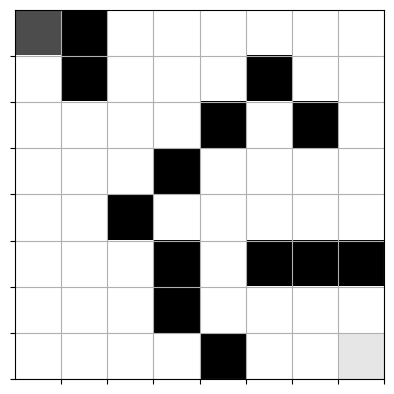

In [9]:
qmaze = TreasureMaze(maze)
show(qmaze)

In [ ]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=500, data_size=20)

Starting Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Stopped epoch 0 early due to reward -0.25 at step 4.
Epoch: 0000/999 | Loss: 0.00898 | Episodes: 4 | Win count: 0 | Win rate: 0.000 | Time: 4.7 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
completion_check(model, qmaze)
show(qmaze)

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)